In [1]:
# 掉包
import re
import nltk
import torch
import string
import gensim
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_packed_sequence
from sklearn.metrics import precision_recall_curve
from matplotlib.font_manager import FontProperties
from torch.nn.utils.rnn import pack_padded_sequence
from keras.preprocessing.sequence import pad_sequences
stopwords = stopwords.words('english')

# 数据预处理

In [2]:
# 文本数据处理
def text_process(text):
    text = text.lower()    
    # 缩写更正

    text = re.sub(r" i'm ", " i am ", text)
    text = re.sub(r" he's ", " he is ", text)
    text = re.sub(r" she's ", " she is ", text)
    text = re.sub(r" it's ", " it is ", text)
    text = re.sub(r" i've ", " i have ", text)
    text = re.sub(r" i'll ", " i will ", text)
    text = re.sub(r" that's ", " that is ", text)        
    text = re.sub(r" what's ", " what is ", text)
    text = re.sub(r" where's ", " where is ", text) 
    text = re.sub(r" can't ", " can not ", text)
    text = re.sub(r" could't ", " could not ", text)
    text = re.sub(r" don't ", " do not ", text)
    text = re.sub(r" did't ", " did not ", text)
    text = re.sub(r" does't ", " does not ", text)
    text = re.sub(r" have't ", " have not", text)
    
    # 符号删除
    text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=]", "", text)
    text = re.sub(r"-", " ", text)
    
    text = text.split(' ')
    # 去停词
#     text = ' '.join([word for word in text.split() if word not in (stopwords)])
    # 分词
#     tokens = word_tokenize(text)
#     text = [word for word in tokens if word.isalpha()]

    
    return text

In [66]:
# 加载训练数据
data = pd.read_csv('./data/train/sentences.txt',sep="\t", header= None, names=["first", "second", "sentence"])
data['label'] = pd.read_table('./data/train/labels.txt', header=None, names=["label"])
data["sentence"] = data["sentence"].apply(text_process)
data["first"] = data["first"].apply(text_process)
data["second"] = data["second"].apply(text_process)

data.head(5)

,first,second,sentence,label
0,[configurationl],[elements],"[the, system, as, described, above, has, its, ...","Component-Whole(e2,e1)"
1,[child],[cradle],"[the, child, was, carefully, wrapped, and, bou...",Other
2,[author],[disassembler],"[the, author, of, a, keygen, uses, a, disassem...","Instrument-Agency(e2,e1)"
3,[ridge],[surge],"[a, misty, ridge, uprises, from, the, surge]",Other
4,[student],[association],"[the, student, association, is, the, voice, of...","Member-Collection(e1,e2)"


#### 确定两个实体在句子中的准确位置

In [95]:
# 寻找实体在句子中出现的所有位置
temp_df = pd.DataFrame()

def find_idx(a,b,sentence):
    idx_a = []
    idx_b = []
    sentence = np.array(sentence)
    
    for i in range(len(a)):
        idx = np.where(sentence==a[i])
        idx = idx[0].tolist()
        idx_a.append(idx)
        
    for i in range(len(b)):
        idx = np.where(sentence==b[i])
        idx = idx[0].tolist()
        idx_b.append(idx)
        
    return idx_a,idx_b

            
temp_df['first_idx'] = data.apply(lambda x:find_idx(x['first'],x['second'],x['sentence'])[0],axis=1)
temp_df['second_idx'] = data.apply(lambda x:find_idx(x['second'],x['second'],x['sentence'])[1],axis=1)
temp_df.head()

,first_idx,second_idx
0,[[3]],[[6]]
1,[[1]],[[4]]
2,[[2]],[[8]]
3,[[5]],[[9]]
4,"[[1, 15]]",[[16]]


In [100]:
# 利用两实体间的位置关系确定准确位置
def judge_idx(a,b):
    idx_a=[]
    idx_b=[]
    if len(a)==1 & len(b)==1:
        if len(a[0])==1:
            idx_a.append(a[0][0])
            if len(b[0])!=1:
                b = np.array(b[0])
                a = np.array(a[0])
                b = b[b>a]
                idx_b.append(b[0])

            else:
                idx_b.append(b[0][0])
        else:
            if len(b[0])==1:
                idx_b.append(b[0][0])
                b = np.array(b[0])
                a = np.array(a[0])
                a = a[a<b]
                if len(a)==1:
                    idx_a.append(a[0])
                else:
                    idx_a.append(a[-1])
            else:
                dis=[]
                tem=[]
                for i in a[0]:
                    for j in b[0]:
                        if i<j:
                            dis.append(j-i)
                            tem.append([i,j])
                            break;
                tar = dis.index(min(dis))
                idx_a.append(tem[tar][0])
                idx_b.append(tem[tar][1])
                
    else:
        if len(a)==1:
            for i in range(len(b)):
                if len(b[i])==1:
                    for j in range(0,i):
                        idx_b.append(b[i][0]-i+j)
                    for j in range(i,len(b)):
                        idx_b.append(b[i][0]+j-i)
                    break

            
            if len(a[0])==1:
                idx_a.append(a[0][0])
            else:
                b = np.array(idx_b[0])
                a = np.array(a[0])
                a = a[a<b]
                if len(a)==1:
                    idx_a.append(a[0])
                else:
                    idx_a.append(a[-1])

        elif len(b)==1:
            for i in range(len(a)):
                if len(a[i])==1:
                    for j in range(0,i):
                        idx_a.append(a[i][0]-i+j)
                    for j in range(i,len(a)):
                        idx_a.append(a[i][0]+j-i)
                    break

            if len(b[0])==1:
                idx_b.append(b[0][0])
            else:
                a = np.array(idx_a[-1])
                b = np.array(b[0])
                b = b[a<b]
                idx_b.append(b[0])      
        
        else:
            for i in range(len(b)):
                if len(b[i])==1:
                    for j in range(0,i):
                        idx_b.append(b[i][0]-i+j)
                    for j in range(i,len(b)):
                        idx_b.append(b[i][0]+j-i)
                    break
                    
            for i in range(len(a)):
                if len(a[i])==1:
                    for j in range(0,i):
                        idx_a.append(a[i][0]-i+j)
                    for j in range(i,len(a)):
                        idx_a.append(a[i][0]+j-i)
                    break
    return idx_a,idx_b                       

data['first_idx'] = temp_df.apply(lambda x:judge_idx(x['first_idx'],x['second_idx'])[0],axis=1)
data['second_idx'] = temp_df.apply(lambda x:judge_idx(x['first_idx'],x['second_idx'])[1],axis=1)
data.head()

1111111
1111111


,first,second,sentence,label,first_idx,second_idx
0,[audits],[waste],"[the, most, common, audits, were, about, waste...","Message-Topic(e1,e2)",[3],[6]
1,[company],[chairs],"[the, company, fabricates, plastic, chairs]","Product-Producer(e2,e1)",[1],[4]
2,[master],[stick],"[the, school, master, teaches, the, lesson, wi...","Instrument-Agency(e2,e1)",[2],[8]
3,[body],[reservoir],"[the, suspect, dumped, the, dead, body, into, ...","Entity-Destination(e1,e2)",[5],[9]
4,[influenza],[virus],"[avian, influenza, is, an, infectious, disease...","Cause-Effect(e2,e1)",[15],[16]


#### 将19个类别进行编码，并将处理好的数据保存pickle格式以保留数据的原始类型

In [69]:
label_encoder = LabelEncoder()
label_encoder.fit(data["label"])
data["Label"] = label_encoder.transform(data["label"])
data.head()

,first,second,sentence,label,Label
0,[configurationl],[elements],"[the, system, as, described, above, has, its, ...","Component-Whole(e2,e1)",3
1,[child],[cradle],"[the, child, was, carefully, wrapped, and, bou...",Other,16
2,[author],[disassembler],"[the, author, of, a, keygen, uses, a, disassem...","Instrument-Agency(e2,e1)",11
3,[ridge],[surge],"[a, misty, ridge, uprises, from, the, surge]",Other,16
4,[student],[association],"[the, student, association, is, the, voice, of...","Member-Collection(e1,e2)",12


In [117]:
data[['first_idx','second_idx','sentence','Label']].to_pickle('./processed_test.pickle')

# 词向量构建

In [306]:
train_data = pd.read_pickle('./processed_train.pickle')

In [307]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([train_data['sentence']],axis=0))
vocab_size = len(tokenizer.word_index) + 1 
vocab_size

19247

In [308]:
embeddings_dict = {}
word2vec=[]
with open('./Word2Vec/glove.6B.100d.txt', 'r',encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        if word in tokenizer.word_index.keys():
            embeddings_dict[word] = vector
            word2vec.append(vector)

In [309]:
# 构建词典
idx2word ={ i:k for i,k in enumerate(embeddings_dict.keys())}
word2idx ={ k:i for i,k in enumerate(embeddings_dict.keys())}

In [310]:
# 定义新词
pad_word,unk_word='<pad>', '<unk>'

new_id=len(word2idx)
idx2word[new_id]=pad_word
word2idx[pad_word]=new_id
idx2word[new_id+1]=unk_word
word2idx[unk_word]=new_id+1
print(word2idx[pad_word])
print(word2idx[unk_word])

18360
18361


In [311]:
# 按照固定长度将文本转换为inx
def word2index(sentence):
    idx=[]
    for i in sentence:
        if i in word2idx.keys():
            idx.append(word2idx[i])
        else:
            idx.append(word2idx['<unk>'])
        
    return idx

In [312]:
train_data = pd.read_pickle('./processed_train.pickle')
train_data['sentence'] = train_data['sentence'].apply(word2index)
train_data['len'] = train_data['sentence'].apply(lambda x: len(x))
train_data.sort_values(['len'],inplace=True,ascending=False)
train_data.reset_index(drop=True, inplace=True)
train_data.head()

,first_idx,second_idx,sentence,Label,len
0,[50],[52],"[15, 10, 2929, 206, 14, 179, 599, 2449, 114, 0...",13,85
1,[24],[27],"[3786, 1876, 9, 0, 774, 1, 3061, 16, 856, 1, 5...",16,82
2,[3],[7],"[527, 4, 10456, 8639, 1, 12869, 2726, 4919, 53...",13,78
3,[64],[69],"[14, 0, 8380, 4403, 330, 3893, 25, 311, 833, 4...",16,70
4,[62],[65],"[0, 14570, 199, 43, 234, 9, 103, 14, 4534, 14,...",16,66


In [313]:
test_data = pd.read_pickle('./processed_test.pickle')
test_data = test_data[test_data['Label']!=16]
test_data.reset_index(drop=True, inplace=True)
test_data['sentence'] = test_data['sentence'].apply(word2index)
test_data['len'] = test_data['sentence'].apply(lambda x: len(x))
test_data.sort_values(['len'],inplace=True,ascending=False)
test_data.reset_index(drop=True, inplace=True)
test_data.head()

,first_idx,second_idx,sentence,Label,len
0,[16],[19],"[4, 48, 18361, 0, 18361, 5396, 2176, 121, 18, ...",13,62
1,[15],[18],"[0, 436, 1061, 10797, 670, 16, 3088, 18361, 0,...",2,57
2,[11],[14],"[0, 18361, 3340, 1, 1317, 9, 5, 352, 2083, 16,...",13,57
3,[48],[51],"[4, 1032, 2, 0, 18361, 0, 291, 1867, 217, 5230...",13,54
4,[16],[18],"[32, 879, 17, 174, 12855, 50, 32, 879, 4, 5, 3...",13,52


# 数据构造

In [11]:
def make_data(sen,e1,e2,Len,Label):
    max_len = len(sen[0])
    mask=np.array([[[False for i in range(max_len)] for i in range(5)] for i in range(len(sen))])
    
    for i in range(len(sen)):
        mask[i][0][0:max(e1[i])+1]=True
        mask[i][1][min(e1[i]):max(e2[i])+1]=True
        mask[i][2][min(e2[i]):Len[i]]=True
        mask[i][3][min(e1[i]):max(e1[i])+1]=True
        mask[i][4][min(e2[i]):max(e2[i])+1]=True
        
    for i in range(len(sen)):
        if len(sen[i])<max_len:
            sen[i].extend(word2idx['<pad>'] for i in range(max_len-len(sen[i])))
            
            
    location=np.array([[[0 for i in range(max_len)] for i in range(2)] for i in range(len(sen))])
    for i in range(len(sen)):
        for j in range(max_len):
            if j in e1[i]:
                location[i][0][j] = 0
            else:
                location[i][0][j] = j-min(e1[i])
            if j in e2[i]:
                location[i][1][j] = 0
            else:
                location[i][1][j] = j-min(e2[i])
        
    location = location.reshape(len(location),-1,len(location[0]))            
    sen = torch.LongTensor(sen)
    Label = torch.LongTensor(Label)
    mask = torch.BoolTensor(mask)
    
    return sen,torch.BoolTensor(mask),Label,location


In [12]:
class TranslateDataSet(Data.Dataset): # 重载Dataset类
    def __init__(self,sen,mask,Label,position):
        self.sen = sen
        self.Label = Label
        self.mask = mask
        self.position = position
        
    def __len__(self): # 获取数据集大小
        return len(self.sen)
    
    def __getitem__(self, idx): # 获取单个字符
        return self.sen[idx], self.mask[idx], self.Label[idx], self.position[idx]

## BiGRU-1

In [314]:
embedding_dim = 100
n_hidden = 64
batch_size = 64

In [322]:
class BiGRU_atten(nn.Module):
    def __init__(self, embedding):
        super(BiGRU_atten, self).__init__()
        self.embedding = embedding
        self.GRU = nn.GRU(embedding_dim, n_hidden, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(n_hidden*6,19)
        self.att_cat = nn.Linear(n_hidden*2+embedding_dim, 1)
        self.att_cat0 = nn.Linear(n_hidden*2, 1)
               
    def dot_atten(self,lstm_output, final_state):
        mask1 = lstm_output.eq(0)
        mask1 = mask1.masked_fill(mask1,float('-inf'))[:,:,0]

        batch_size = len(lstm_output)
        # final_state[0]---正向；final_state[1]---逆向。
        hidden_ = torch.concat((final_state[0],final_state[1]),dim=-1)
        # hidden_: [B,H*2]
        hidden = hidden_.unsqueeze(-1)

        # lstm_out:[B, max_w_len, H*2] hidden:[B,H*2,1] atten_weight:[B,max_w_len,1]
        atten_weights = (torch.bmm(lstm_output, hidden)+mask1.unsqueeze(-1)).squeeze(2)
        soft_atten_weights = F.softmax(atten_weights,1).unsqueeze(2)

        # lstm_out:[B, max_w_len, H*2] ->[B, H*2,max_w_len] soft_attn_weights:[B,max_w_len,1]
        lstm_output = lstm_output.transpose(1,2)
        context = torch.bmm(lstm_output,soft_atten_weights).squeeze(2)
        
        return context
    
    def attention_net(self,lstm_output):
        mask3 = lstm_output.eq(0)
        mask3 = mask3.masked_fill(mask3,float('-inf'))[:,:,0]
        
        attn_weights = torch.tanh(self.att_cat0(lstm_output))
        attn_weights= (attn_weights+mask3.unsqueeze(-1)).squeeze(2)       
        
        soft_attn_weights = F.softmax(attn_weights,1)
        context = torch.bmm(lstm_output.transpose(2,1),soft_attn_weights.unsqueeze(2)).squeeze(2)
        context = torch.tanh(context)
        
        return context
       
    def entity_atten(self,lstm_output,e):
        # lstm_output : [batch_size, max_w_len, n_hidden * num_directions(=2)]
        # e : [B, embedding]
        mask2 = lstm_output.eq(0)
        mask2 = mask2.masked_fill(mask2,float('-inf'))[:,:,0]
        
        # [B,len,emb+H*2][B,emb,1] [B,len,1]
        E = e.repeat(1,lstm_output.size(1)).reshape(lstm_output.size(0),lstm_output.size(1),embedding_dim)
        HE = torch.cat((lstm_output,E),dim=-1)
        attn_weights = torch.tanh(self.att_cat(HE))
        attn_weights= (attn_weights+mask2.unsqueeze(-1)).squeeze(2)
#         attn_weights= (torch.bmm(HE,e.unsqueeze(-1))).squeeze(2)

        soft_attn_weights = F.softmax(attn_weights,1)
        context = torch.bmm(lstm_output.transpose(2,1),soft_attn_weights.unsqueeze(2)).squeeze(2)
        context = torch.tanh(context)
        
        return context

    def forward(self,X,mask):
        x = X
        x.copy_(X)
        x = x.numpy().tolist()
        word_len = [i.index(word2idx['<pad>']) if i[-1]==word2idx['<pad>'] else len(i) for i in x]
        
        x_input = self.embedding(X)
        
        embed_input_x_packed = pack_padded_sequence(x_input,word_len,batch_first=True)
        output,final_hidden_state = self.GRU(embed_input_x_packed)
        output,_ = pad_packed_sequence(output, batch_first=True)
        output = F.dropout(output,p=0.2)
        
        # [B,5,max_len]->[B,3,seq_len]->[H*2,B,seq_len]->[B,seq_len,H*2]
        mask = mask[:,:,0:max(word_len)]
        mask = mask.repeat(n_hidden*2,1,1,1).permute(1,2,3,0)
        
        x_input = x_input[:,0:max(word_len),:]
        e1 = [x_input[i][mask[:,3,:,0:embedding_dim][i]].reshape(-1,embedding_dim) for i in range(output.size(0))]
        e1 = [F.avg_pool1d(ei.permute(1,0),kernel_size=ei.size(0)).detach().numpy().tolist() for ei in e1]
        e1 = torch.Tensor(np.array(e1)).squeeze(-1)
        e2 = [x_input[i][mask[:,4,:,0:embedding_dim][i]].reshape(-1,embedding_dim) for i in range(output.size(0))]
        e2 = [F.avg_pool1d(ei.permute(1,0),kernel_size=ei.size(0)).detach().numpy().tolist() for ei in e2]
        e2 = torch.Tensor(np.array(e2)).squeeze(-1)
        
        hidden_ = self.attention_net(output)

        E1 = self.entity_atten(output,e1)
        E2 = self.entity_atten(output,e2)

        context = torch.concat([E1,E2,hidden_],dim=-1)
        context = F.dropout(context,p=0.5)
        context = self.linear(context)
        
        return context
# 

In [323]:
# 构建词向量，并添加到权值矩阵中
weights = torch.FloatTensor(np.array(word2vec))
pad_vec=np.random.uniform(-np.sqrt(3.0 / embedding_dim), np.sqrt(3.0 / embedding_dim), embedding_dim)
pad_vec=torch.Tensor(pad_vec).view(1,-1)
weights=torch.cat([weights,pad_vec],dim=0)

unk_vec=np.random.uniform(-np.sqrt(3.0 / embedding_dim), np.sqrt(3.0 / embedding_dim), embedding_dim)
unk_vec=torch.Tensor(unk_vec).view(1,-1)
weights=torch.cat([weights,unk_vec],dim=0)
print(weights.shape)

embedding1 = nn.Embedding.from_pretrained(embeddings=weights, freeze=False)

torch.Size([18362, 100])


In [290]:
model1 = BiGRU_atten(embedding1)
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adagrad(model1.parameters(), lr=0.01,weight_decay=1e-5)

train_sen, train_mask, train_label, train_position = make_data(train_data['sentence'], train_data['first_idx'], 
                        train_data['second_idx'],train_data['len'], train_data['Label'])

test_sen, test_mask, test_label, test_position = make_data(test_data['sentence'], test_data['first_idx'], 
                        test_data['second_idx'],test_data['len'], test_data['Label'])

loader1 = Data.DataLoader(TranslateDataSet(train_sen, train_mask, train_label,train_position),batch_size, False)

In [64]:
train_acc_lst1,test_acc_lst1=[],[]
train_loss_lst1,test_loss_lst1=[],[]

for epoch in range(30):
    model1.train()
    for i,(sen,mask,label,_) in enumerate(loader1):
        pred = model1(sen,mask)
        loss = criterion(pred,label)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
    
    model1.eval()
    train_pred = model1(train_sen,train_mask)
    train_loss = criterion(train_pred,train_label)
    train_loss_lst1.append(train_loss.item())
    _,train_pre_label = torch.max(train_pred, 1)
    train_acc = accuracy_score(train_pre_label, train_label)
    train_acc_lst1.append(train_acc)
    
    test_pred = model1(test_sen,test_mask)
    test_loss = criterion(test_pred,test_label)
    test_loss_lst1.append(test_loss.item())
    _,test_pre_label = torch.max(test_pred, 1)
    test_acc = accuracy_score(test_pre_label, test_label)
    test_acc_lst1.append(test_acc)
    
    print('Epoch: %02d/30:' % (epoch+1),'train_loss = {:.6f}, test_loss = {:.6f}, train_acc = {:.6f}, test_acc = {:.6f}'.format(train_loss,test_loss,train_acc,test_acc))   

Epoch: 01/30: train_loss = 1.779963, test_loss = 2.098791, train_acc = 0.405500, test_acc = 0.273531
Epoch: 02/30: train_loss = 1.284909, test_loss = 1.829400, train_acc = 0.540750, test_acc = 0.370305
Epoch: 03/30: train_loss = 0.972697, test_loss = 1.759029, train_acc = 0.628000, test_acc = 0.407424
Epoch: 04/30: train_loss = 0.749614, test_loss = 1.821399, train_acc = 0.708500, test_acc = 0.417587
Epoch: 05/30: train_loss = 0.485067, test_loss = 1.748904, train_acc = 0.813875, test_acc = 0.472382
Epoch: 06/30: train_loss = 0.294623, test_loss = 1.627995, train_acc = 0.892000, test_acc = 0.524967
Epoch: 07/30: train_loss = 0.197455, test_loss = 1.559158, train_acc = 0.931000, test_acc = 0.560318
Epoch: 08/30: train_loss = 0.109935, test_loss = 1.448465, train_acc = 0.967375, test_acc = 0.602740
Epoch: 09/30: train_loss = 0.077216, test_loss = 1.431951, train_acc = 0.980375, test_acc = 0.629253
Epoch: 10/30: train_loss = 0.054857, test_loss = 1.461567, train_acc = 0.987875, test_acc =

In [ ]:
torch.save(model1.state_dict(),'BiGRU-1.pkl')
Re = pd.DataFrame({'train_loss':train_loss_lst1,'test_loss':test_loss_lst1
                  ,'train_acc':train_acc_lst1,'test_acc':test_acc_lst1})
Re.to_csv('./BiGRU-1.csv')

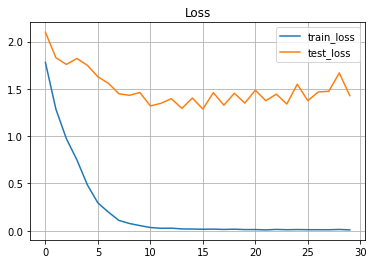

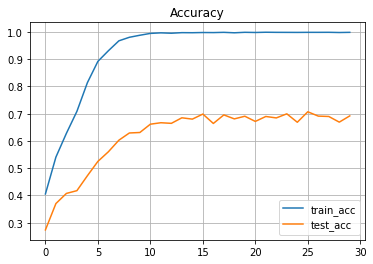

In [66]:
# 绘制loss、f1曲线图
plt.plot(np.arange(30),train_loss_lst3,label="train_loss")
plt.plot(np.arange(30),test_loss_lst3,label="test_loss")
plt.legend()
plt.grid()
plt.title('Loss')
plt.show()

plt.plot(np.arange(30),train_acc_lst3,label="train_acc")
plt.plot(np.arange(30),test_acc_lst3,label="test_acc")
plt.legend()
plt.grid()
plt.title('Accuracy')
plt.show()

## BiGRU-2

In [316]:
class BiGRU_pool(nn.Module):
    def __init__(self, embedding):
        super(BiGRU_pool, self).__init__()
        self.embedding = embedding
        self.GRU = nn.GRU(embedding_dim, n_hidden, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(n_hidden*14+embedding_dim*2,n_hidden*2)
        self.out = nn.Linear(n_hidden*2, 19)

    def attention_net(self,lstm_output, final_state):
        mask1 = lstm_output.eq(0)
        mask1 = mask1.masked_fill(mask1,float('-inf'))[:,:,0]

        batch_size = len(lstm_output)
        # final_state[0]---正向；final_state[1]---逆向。
        hidden_ = torch.concat((final_state[0],final_state[1]),dim=-1)
        # hidden_: [B,H*2]
        hidden = hidden_.unsqueeze(-1)

        # lstm_out:[B, max_w_len, H*2] hidden:[B,H*2,1] atten_weight:[B,max_w_len,1]
        atten_weights = (torch.bmm(lstm_output, hidden)+mask1.unsqueeze(-1)).squeeze(2)
        soft_atten_weights = F.softmax(atten_weights,1).unsqueeze(2)

        # lstm_out:[B, max_w_len, H*2] ->[B, H*2,max_w_len] soft_attn_weights:[B,max_w_len,1]
        lstm_output = lstm_output.transpose(1,2)
        context = torch.bmm(lstm_output,soft_atten_weights).squeeze(2)
        
        return context, soft_atten_weights
    
    def forward(self,X,mask):
        x = X
        x.copy_(X)
        x = x.numpy().tolist()
        word_len = [i.index(word2idx['<pad>']) if i[-1]=='<pad>' else len(i) for i in x]
        
        x_input = self.embedding(X)
        
        embed_input_x_packed = pack_padded_sequence(x_input,word_len,batch_first=True)
        output,final_hidden_state = self.GRU(embed_input_x_packed)
        output,_ = pad_packed_sequence(output, batch_first=True)
        
        # [B,5,max_len]->[B,3,seq_len]->[H*2,B,seq_len]->[B,seq_len,H*2]
        mask = mask[:,:,0:max(word_len)]
        mask = mask.repeat(n_hidden*2,1,1,1).permute(1,2,3,0)
        output = F.dropout(output,p=0.2)
        
        e1 = [x_input[i][mask[:,3,:,0:embedding_dim][i]].reshape(-1,embedding_dim) for i in range(output.size(0))]
        e1 = [F.avg_pool1d(ei.permute(1,0),kernel_size=ei.size(0)).detach().numpy().tolist() for ei in e1]
        e1 = torch.Tensor(np.array(e1)).squeeze(-1)
        e2 = [x_input[i][mask[:,4,:,0:embedding_dim][i]].reshape(-1,embedding_dim) for i in range(output.size(0))]
        e2 = [F.avg_pool1d(ei.permute(1,0),kernel_size=ei.size(0)).detach().numpy().tolist() for ei in e2]
        e2 = torch.Tensor(np.array(e2)).squeeze(-1)
        
        p1 = [output[i][mask[:,0,:,:][i]].reshape(-1,n_hidden*2) for i in range(output.size(0))]
        p1max = [F.max_pool1d(pi.permute(1,0),kernel_size=pi.size(0)).detach().numpy().tolist() for pi in p1]
        p1max = torch.Tensor(np.array(p1max))
        p1avg = [F.avg_pool1d(pi.permute(1,0),kernel_size=pi.size(0)).detach().numpy().tolist() for pi in p1]
        p1avg = torch.Tensor(np.array(p1avg))
        m1= torch.concat((p1max.squeeze(-1),p1avg.squeeze(-1)),dim=-1)
        
        p2 = [output[i][mask[:,1,:,:][i]].reshape(-1,n_hidden*2) for i in range(output.size(0))]
        p2max = [F.max_pool1d(pi.permute(1,0),kernel_size=pi.size(0)).detach().numpy().tolist() for pi in p2]
        p2max = torch.Tensor(np.array(p2max))
        p2avg = [F.avg_pool1d(pi.permute(1,0),kernel_size=pi.size(0)).detach().numpy().tolist() for pi in p2]
        p2avg = torch.Tensor(np.array(p2avg))
        m2= torch.concat((p2max.squeeze(-1),p2avg.squeeze(-1)),dim=-1)
        
        p3 = [output[i][mask[:,2,:,:][i]].reshape(-1,n_hidden*2) for i in range(output.size(0))]
        p3max = [F.max_pool1d(pi.permute(1,0),kernel_size=pi.size(0)).detach().numpy().tolist() for pi in p3]
        p3max = torch.Tensor(np.array(p3max))
        p3avg = [F.avg_pool1d(pi.permute(1,0),kernel_size=pi.size(0)).detach().numpy().tolist() for pi in p3]
        p3avg = torch.Tensor(np.array(p3avg))
        m3= torch.concat((p3max.squeeze(-1),p3avg.squeeze(-1)),dim=-1)
        
        hidden_, attention = self.attention_net(output,final_hidden_state)

        context = torch.concat([m1,e1,m2,e2,m3,hidden_],dim=-1)
        context = F.dropout(context,p=0.2)
        context = self.linear(context)
        context = F.dropout(context,p=0.5)

        return self.out(context)


In [303]:
class RankingLossFunc(nn.Module):
    def __init__(self):
        super(RankingLossFunc, self).__init__()
        self.mPos = 2.5
        self.mNeg = 0.5
        self.gamma = 0.05

    def forward(self, pred, target):
        value, index = torch.topk(pred,2,dim=1) # top2 score
        noneOtherInd = target!=16 # not Other index
        rows = torch.tensor(list(range(len(pred)))) #row index
        part1 = pred[rows,target] # label score
        part1 = torch.log(1+torch.exp(self.gamma*(self.mPos-part1)))
        predT = index[:,0]==target
        predF = index[:,0]!=target
        part2 = torch.log(1+torch.exp(self.gamma*(self.mNeg+value))) 
        part2 = torch.dot(predT.float(),part2[:,1])+torch.dot(predF.float(),part2[:,0])
        loss = torch.dot(noneOtherInd.float(),part1)+part2 # exclusive other loss
        return loss/len(target)

In [317]:
model2 = BiGRU_pool(embedding1)
criterion = nn.CrossEntropyLoss()
# rankingloss = RankingLoss()
optimizer2 = torch.optim.Adagrad(model2.parameters(), lr=0.01, weight_decay=1e-4)

In [110]:
train_acc_lst2,test_acc_lst2=[],[]
train_loss_lst2,test_loss_lst2=[],[]

for epoch in range(30):
    model2.train()
    for i,(sen,mask,label,_) in enumerate(loader1):
        pred = model2(sen,mask)
        loss = criterion(pred,label)
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
    
    model2.eval()
    train_pred = model1(train_sen,train_mask)
    train_loss = criterion(train_pred,train_label)
    train_loss_lst2.append(train_loss.item())
    _,train_pre_label = torch.max(train_pred, 1)
    train_acc = accuracy_score(train_pre_label, train_label)
    train_acc_lst2.append(train_acc)
    
    test_pred = model2(test_sen,test_mask)
    test_loss = criterion(test_pred,test_label)
    test_loss_lst2.append(test_loss.item())
    _,test_pre_label = torch.max(test_pred, 1)
    test_acc = accuracy_score(test_pre_label, test_label)
    test_acc_lst2.append(test_acc)
    
    print('Epoch: %02d/30:' % (epoch+1),'train_loss = {:.6f}, test_loss = {:.6f}, train_acc = {:.6f}, test_acc = {:.6f}'.format(train_loss,test_loss,train_acc,test_acc))   

Epoch: 01/30: train_loss = 1.758764, test_loss = 1.968540, train_acc = 0.404125, test_acc = 0.323906
Epoch: 02/30: train_loss = 1.459047, test_loss = 1.594306, train_acc = 0.515125, test_acc = 0.463544
Epoch: 03/30: train_loss = 1.247008, test_loss = 1.357753, train_acc = 0.599125, test_acc = 0.567388
Epoch: 04/30: train_loss = 1.158504, test_loss = 1.266977, train_acc = 0.622625, test_acc = 0.602740
Epoch: 05/30: train_loss = 1.053501, test_loss = 1.117918, train_acc = 0.665500, test_acc = 0.655325
Epoch: 06/30: train_loss = 0.995885, test_loss = 1.052633, train_acc = 0.689625, test_acc = 0.684490
Epoch: 07/30: train_loss = 0.958163, test_loss = 0.974881, train_acc = 0.703500, test_acc = 0.718957
Epoch: 08/30: train_loss = 0.977247, test_loss = 0.977773, train_acc = 0.698375, test_acc = 0.726027
Epoch: 09/30: train_loss = 0.902014, test_loss = 0.921076, train_acc = 0.729500, test_acc = 0.733540
Epoch: 10/30: train_loss = 0.846723, test_loss = 0.923086, train_acc = 0.743500, test_acc =

In [76]:
torch.save(model2.state_dict(),'BiGRU-2.pkl')
Re = pd.DataFrame({'train_loss':train_loss_lst2,'test_loss':test_loss_lst2
                  ,'train_acc':train_acc_lst2,'test_acc':test_acc_lst2})
Re.to_csv('./BiGRU-2.csv')

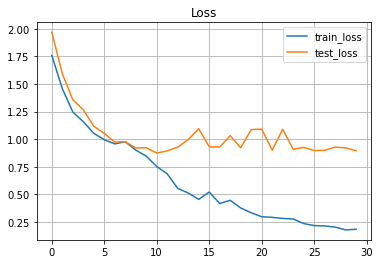

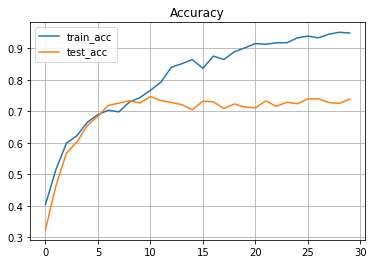

In [109]:
# 绘制loss、f1曲线图
plt.plot(np.arange(30),train_loss_lst2,label="train_loss")
plt.plot(np.arange(30),test_loss_lst2,label="test_loss")
plt.legend()
plt.grid()
plt.title('Loss')
plt.show()

plt.plot(np.arange(30),train_acc_lst2,label="train_acc")
plt.plot(np.arange(30),test_acc_lst2,label="test_acc")
plt.legend()
plt.grid()
plt.title('Accuracy')
plt.show()

## PCNN

In [266]:
class PCNN(nn.Module):
    # 多通道textcnn
    def __init__(self,embedding_dim,embedding):
        super(PCNN, self).__init__()
        self.embedding = embedding
        self.location_emb = nn.Embedding(155,25)
        self.convs = nn.Conv1d(in_channels=embedding_dim*3+50,out_channels=100,kernel_size=3,padding=1)
        self.linear = nn.Linear(100*4, 19)

    def forward(self, X,mask,location): 
        x = X
        x.copy_(X)
        x = x.numpy().tolist()
        word_len = [i.index(word2idx['<pad>']) if i[-1]==word2idx['<pad>'] else len(i) for i in x]
        x_input = X[:,0:max(word_len)]
        location = location[:,0:max(word_len),:]
        
        x_input = self.embedding(x_input)
        location0 = self.location_emb(location[:,:,0])
        location1 = self.location_emb(location[:,:,1])
        location = torch.concat((location0,location1),dim=-1)
        
        mask = mask[:,:,0:max(word_len)]
        mask = mask.repeat(100,1,1,1).permute(1,2,0,3)     
        # mask torch.Size([64, 5, 100, 85])
        
        e1 = [x_input[i][mask[:,3,:,:][i].transpose(0,1)].reshape(-1,embedding_dim) for i in range(x_input.size(0))]
        e1 = [F.avg_pool1d(ei.permute(1,0),kernel_size=ei.size(0)).detach().numpy().tolist() for ei in e1]
        e1 = torch.Tensor(np.array(e1))
        e2 = [x_input[i][mask[:,4,:,:][i].transpose(0,1)].reshape(-1,embedding_dim) for i in range(x_input.size(0))]
        e2 = [F.avg_pool1d(ei.permute(1,0),kernel_size=ei.size(0)).detach().numpy().tolist() for ei in e2]
        e2 = torch.Tensor(np.array(e2))
        
        e1 = e1.repeat(1,1,max(word_len)).transpose(1,2)
        e2 = e2.repeat(1,1,max(word_len)).transpose(1,2)
        x_input = torch.concat((x_input,e1,e2),dim=-1)
        x_input = F.dropout(x_input,p=0.5)

        x = F.relu(self.convs(x_input.transpose(1,2)))
        # torch.Size([B, 100, 85]
        xmax = F.max_pool1d(x,kernel_size=x.size(2)).squeeze(-1)

        p1 = [x[i][mask[:,0,0:100,:][i]].reshape(100,-1) for i in range(x.size(0))]
        p1max = [F.max_pool1d(pi,kernel_size=pi.size(1)).detach().numpy().tolist() for pi in p1]
        p1max = torch.Tensor(np.array(p1max))
        
        p2 = [x[i][mask[:,1,0:100,:][i]].reshape(100,-1) for i in range(x.size(0))]
        p2max = [F.max_pool1d(pi,kernel_size=pi.size(1)).detach().numpy().tolist() for pi in p2]
        p2max = torch.Tensor(np.array(p2max))
        
        p3 = [x[i][mask[:,2,0:100,:][i]].reshape(100,-1) for i in range(x.size(0))]
        p3max = [F.max_pool1d(pi,kernel_size=pi.size(1)).detach().numpy().tolist() for pi in p3]
        p3max = torch.Tensor(np.array(p3max))

        x = torch.concat((p1max.squeeze(-1),p2max.squeeze(-1),p3max.squeeze(-1),xmax),dim=-1)
        x = F.dropout(x,p=0.5)
        # torch.Size([64, 300])
        out = self.linear(x)
        
        return out
    

#### 对位置信息进行编码

In [ ]:
num_list = []
for i in range(8000):
    for j in range(85):
        if train_position[i][j][0] not in num_list:
            num_list.append(train_position[i][j][0])
        if train_position[i][j][1] not in num_list:
            num_list.append(train_position[i][j][1])

# 构建词典
idx2word_ ={ i:k for i,k in enumerate(num_list)}
word2idx_ ={ k:i for i,k in enumerate(num_list)}

In [ ]:
train_position_ = train_position.copy()
for i in range(len(train_position_)):
    for j in range(len(train_position_[0])):
        train_position_[i][j][0]=word2idx_[train_position_[i][j][0]]
        train_position_[i][j][1]=word2idx_[train_position_[i][j][1]]
        
test_position_ = test_position.copy()
for i in range(len(test_position_)):
    for j in range(len(test_position_[0])):
        test_position_[i][j][0]=word2idx_[test_position_[i][j][0]]
        test_position_[i][j][1]=word2idx_[test_position_[i][j][1]]
        
train_position_ = torch.tensor(train_position_)
test_position_ = torch.tensor(test_position_)

In [212]:
class RankingLossFunc(nn.Module):
    def __init__(self):
        super(RankingLossFunc, self).__init__()
        self.mPos = 2.5
        self.mNeg = 0.5
        self.gamma = 0.05

    def forward(self, pred, target):
        value, index = torch.topk(pred,2,dim=1) # top2 score
        noneOtherInd = target!=16 # not Other index
        rows = torch.tensor(list(range(len(pred)))) #row index
        part1 = pred[rows,target] # label score
        part1 = torch.log(1+torch.exp(self.gamma*(self.mPos-part1)))
        predT = index[:,0]==target
        predF = index[:,0]!=target
        part2 = torch.log(1+torch.exp(self.gamma*(self.mNeg+value))) 
        part2 = torch.dot(predT.float(),part2[:,1])+torch.dot(predF.float(),part2[:,0])
        loss = torch.dot(noneOtherInd.float(),part1)+part2 # exclusive other loss
        return loss/len(target)

In [218]:
embedding_dim=100
model3 = PCNN(embedding_dim,embedding1)
criterion = nn.CrossEntropyLoss()
# criterion = RankingLossFunc()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001, weight_decay=1e-5)

In [223]:
train_acc_lst3,test_acc_lst3=[],[]
train_loss_lst3,test_loss_lst3=[],[]

for epoch in range(30):
    model3.train()
    for i,(sen,mask,label,position) in enumerate(loader3):
        for i in range(len(position)):
            for j in range(len(position[0])):
                position[i][j][0]=word2idx_[position[i][j][0].item()]
                position[i][j][1]=word2idx_[position[i][j][1].item()]
        pred = model3(sen,mask,position)
        loss = criterion(pred,label)
        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
    
    model3.eval()
    train_pred = model3(train_sen,train_mask,train_position_)
    train_loss = criterion(train_pred,train_label)
    train_loss_lst3.append(train_loss.item())
    _,train_pre_label = torch.max(train_pred, 1)
    train_acc = accuracy_score(train_pre_label, train_label)
    train_acc_lst3.append(train_acc)
    
    test_pred = model3(test_sen,test_mask,test_position_)
    test_loss = criterion(test_pred,test_label)
    test_loss_lst3.append(test_loss.item())
    _,test_pre_label = torch.max(test_pred, 1)
    test_acc = accuracy_score(test_pre_label, test_label)
    test_acc_lst3.append(test_acc)
    
    print('Epoch: %02d/30:' % (epoch+1),'train_loss = {:.6f}, test_loss = {:.6f}, train_acc = {:.6f}, test_acc = {:.6f}'.format(train_loss,test_loss,train_acc,test_acc))   

Epoch: 01/30: train_loss = 1.334816, test_loss = 1.474843, train_acc = 0.286750, test_acc = 0.319929
Epoch: 02/30: train_loss = 1.318322, test_loss = 1.472370, train_acc = 0.349000, test_acc = 0.390632
Epoch: 03/30: train_loss = 1.278869, test_loss = 1.439586, train_acc = 0.404250, test_acc = 0.459567
Epoch: 04/30: train_loss = 1.224393, test_loss = 1.391319, train_acc = 0.462875, test_acc = 0.524967
Epoch: 05/30: train_loss = 1.154346, test_loss = 1.332301, train_acc = 0.541125, test_acc = 0.608926
Epoch: 06/30: train_loss = 1.097938, test_loss = 1.287055, train_acc = 0.578625, test_acc = 0.648696
Epoch: 07/30: train_loss = 1.052712, test_loss = 1.248393, train_acc = 0.606125, test_acc = 0.687141
Epoch: 08/30: train_loss = 1.005921, test_loss = 1.221925, train_acc = 0.631125, test_acc = 0.715864
Epoch: 09/30: train_loss = 0.966920, test_loss = 1.203507, train_acc = 0.648125, test_acc = 0.722050
Epoch: 10/30: train_loss = 0.928313, test_loss = 1.163204, train_acc = 0.660000, test_acc =

In [222]:
torch.save(model3.state_dict(),'BiGRU_whole_3.pkl')
Re = pd.DataFrame({'train_loss':train_loss_lst3,'test_loss':test_loss_lst3
                  ,'train_acc':train_acc_lst3,'test_acc':test_acc_lst3})
Re.to_csv('./BiGRU_whole_3.csv')

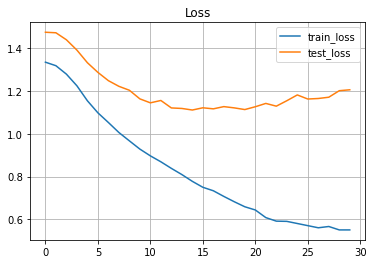

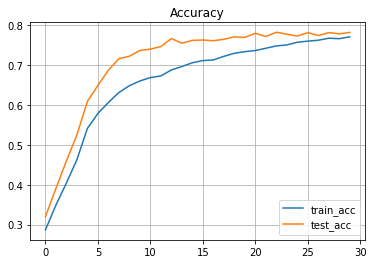

In [224]:
# 绘制loss、f1曲线图
plt.plot(np.arange(30),train_loss_lst3,label="train_loss")
plt.plot(np.arange(30),test_loss_lst3,label="test_loss")
plt.legend()
plt.grid()
plt.title('Loss')
plt.show()

plt.plot(np.arange(30),train_acc_lst3,label="train_acc")
plt.plot(np.arange(30),test_acc_lst3,label="test_acc")
plt.legend()
plt.grid()
plt.title('Accuracy')
plt.show()

## 模型评价

In [ ]:
test_sen, test_mask, test_label, test_position = make_data(test_data['sentence'], test_data['first_idx'], 
                        test_data['second_idx'],test_data['len'], test_data['Label'])

In [319]:
BiGRU_atten = BiGRU_atten(embedding1)
BiGRU_atten.load_state_dict(torch.load("./BiGRU-1.pkl"))
BiGRU_pool = BiGRU_pool(embedding1)
BiGRU_pool.load_state_dict(torch.load("./BiGRU-2.pkl"))
PCNN = PCNN(embedding_dim,embedding1)
PCNN.load_state_dict(torch.load("./PCNN.pkl"))

<All keys matched successfully>

In [320]:
pred_lst1 =[]
BiGRU_atten.eval()
pred = BiGRU_atten(test_sen,test_mask)
_,pre_label = torch.max(pred, 1)
pred_lst1.append(pre_label.data)

pred_lst2 =[]
BiGRU_pool.eval()
pred = BiGRU_pool(test_sen,test_mask)
_,pre_label = torch.max(pred, 1)
pred_lst2.append(pre_label.data)

pred_lst3 =[]
PCNN.eval()
pred = PCNN(test_sen,test_mask,test_position_)
_,pre_label = torch.max(pred, 1)
pred_lst3.append(pre_label.data)


In [296]:
print(classification_report(test_label.numpy(),np.array(pred_lst1[0]),digits=4))

              precision    recall  f1-score   support

           0     0.8430    0.7612    0.8000       134
           1     0.8547    0.7577    0.8033       194
           2     0.6400    0.4938    0.5575       162
           3     0.4769    0.4133    0.4429       150
           4     0.7974    0.7974    0.7974       153
           5     0.7241    0.5385    0.6176        39
           6     0.8559    0.6735    0.7538       291
           7     0.0000    0.0000    0.0000         1
           8     0.7532    0.5498    0.6356       211
           9     0.6486    0.5106    0.5714        47
          10     0.2143    0.1364    0.1667        22
          11     0.4133    0.4627    0.4366       134
          12     0.4167    0.1562    0.2273        32
          13     0.7472    0.6617    0.7018       201
          14     0.8062    0.4952    0.6136       210
          15     0.7576    0.4902    0.5952        51
          16     0.0000    0.0000    0.0000         0
          17     0.4622    

In [321]:
print(classification_report(test_label.numpy(),np.array(pred_lst2[0]),digits=4))

              precision    recall  f1-score   support

           0     0.8718    0.7612    0.8127       134
           1     0.8382    0.8814    0.8593       194
           2     0.6290    0.7222    0.6724       162
           3     0.5536    0.6200    0.5849       150
           4     0.7750    0.8105    0.7923       153
           5     0.5366    0.5641    0.5500        39
           6     0.8525    0.8935    0.8725       291
           7     0.0000    0.0000    0.0000         1
           8     0.8358    0.7962    0.8155       211
           9     0.8649    0.6809    0.7619        47
          10     0.4000    0.1818    0.2500        22
          11     0.5847    0.5149    0.5476       134
          12     0.8182    0.2812    0.4186        32
          13     0.8163    0.7960    0.8060       201
          14     0.7476    0.7333    0.7404       210
          15     0.7576    0.4902    0.5952        51
          16     0.0000    0.0000    0.0000         0
          17     0.7938    

In [273]:
print(classification_report(test_label.numpy(),np.array(pred_lst3[0]),digits=4))

              precision    recall  f1-score   support

           0     0.8682    0.8358    0.8517       134
           1     0.8743    0.8608    0.8675       194
           2     0.7256    0.7346    0.7301       162
           3     0.6012    0.6733    0.6352       150
           4     0.8411    0.8301    0.8355       153
           5     0.7222    0.6667    0.6933        39
           6     0.8323    0.8866    0.8586       291
           7     0.0000    0.0000    0.0000         1
           8     0.7880    0.8104    0.7991       211
           9     0.7917    0.8085    0.8000        47
          10     0.3500    0.3182    0.3333        22
          11     0.6697    0.5448    0.6008       134
          12     0.8182    0.5625    0.6667        32
          13     0.8140    0.8706    0.8413       201
          14     0.8057    0.8095    0.8076       210
          15     0.6071    0.6667    0.6355        51
          17     0.8280    0.7130    0.7662       108
          18     0.6179    